In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors

Note: The plots here might be slightly different, as this file was ran again while submission.

Authors:<br>
Akranth Reddy me20b100@smail.iitm.ac.in<br>
Hemanth me20b045@smail.iitm.ac.in

# Environment

In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

In [4]:
import random
def epsilon_policy(Q, state, epsilon):
    #implement another dynamically changeing policy
    p = np.random.rand()
    if p<epsilon:
        random_number = random.choice([0, 1, 2, 3])
        return random_number
    else:
        return np.argmax(Q[state,:])
    
def softmax_policy(Q, state, tau=1.0):
    
    x = Q[state,:]/tau
    x = x - np.max(x) 
    x = np.exp(x)
    x = x/np.sum(x)
    p = x.flatten()
    return np.random.choice([0, 1, 2, 3], p = p)
    

In [31]:
def updated_action(action, p, b):
    #Stochastic action selection
    
    r = np.random.random()
    l = [p, (1-p)*b, (1-p)*(1-b)]
    if(action==0):
        if(r<=l[0]):
            return action
        elif(r<l[0]+l[1]):
            return 2
        else:
            return 3
    elif(action==1):
        if(r<=l[0]):
            return action
        elif(r<l[0]+l[1]):
            return 3
        else:
            return 2
    elif(action==2):
        if(r<=l[0]):
            return action
        elif(r<l[0]+l[1]):
            return 1
        else:
            return 0
    else:
        if(r<=l[0]):
            return action
        elif(r<l[0]+l[1]):
            return 0
        else:
            return 1

In [6]:
def run_episode_SARSA(Q, policy, env, alpha, gamma, epsilon, b,p, state_visit):
    max_episodes = 100
    terminate = False
    current_episode_length = 0
    present_state = env.start_state_seq
    next_state = None
    total_reward = 0.0
    b = b
    p = p

    action = policy(Q, present_state, epsilon)
    action = updated_action(action, p, b)

    while not terminate and current_episode_length<max_episodes:
        #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
        
        next_state, reward = env.step(present_state, action)
        action_next = policy(Q, next_state, epsilon)
        action_next = updated_action(action_next, p, b)
        
        Q[present_state,action] += alpha*(reward[0] + gamma*Q[next_state,action_next] - Q[present_state, action])
        state_visit[present_state] += 1
        
        present_state = next_state
        action = action_next
        
        current_episode_length += 1
        total_reward+=reward[0]

        for i in env.goal_states_seq:
            if(i==present_state):
                terminate = True
                total_reward+=10.0 #reward for reaching the goal

                break
    
    return Q, current_episode_length, total_reward, state_visit



In [7]:
def run_episode_Q_Learning(Q, policy, env, alpha, gamma, epsilon, b,p, state_visit):
    max_episodes = 100
    terminate = False
    current_episode_length = 0
    present_state = env.start_state_seq
    next_state = None
    total_reward = 0.0
    b = b
    p = p

    action = policy(Q, present_state, epsilon)
    action = updated_action(action, p, b)

    while not terminate and current_episode_length<max_episodes:
        #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
        
        next_state, reward = env.step(present_state, action)
        action_next = policy(Q, next_state, epsilon)
        action_next = updated_action(action_next, p, b)
        
        Q[present_state,action] += alpha*(reward[0] + gamma*np.max(Q[next_state,:]) - Q[present_state, action])
        state_visit[present_state] += 1

        present_state = next_state
        action = action_next
        
        current_episode_length += 1
        total_reward+=reward[0]

        for i in env.goal_states_seq:
            if(i==present_state):
                terminate = True
                total_reward+=10.0 #reward for reaching the goal
                break
    
    return Q, current_episode_length, total_reward, state_visit



In [8]:
def train_agent(env, policy, alpha, gamma, epsilon, episodes, b, p, run_for, algorithm, policy_name="softmax"):
    #initialize Q
    Q_table = np.zeros((env.num_states, env.num_actions), dtype=float)
    count = 1
    avg_total_steps = []
    avg_total_reward = []
    state_visit = np.zeros(env.num_states)

    while(count<=run_for):
        print(f'Running for {count}')
        total_steps = []
        total_reward = []
        for i in range(episodes):
            if policy_name!="softmax":
                epsilon = epsilon*0.999
            Q_table, steps, reward, state_visit = algorithm(Q_table, policy, env, alpha, gamma, epsilon,b, p, state_visit)
            if(i%100==0):
                #print(f'Episode terminated number of steps {steps} | Reward {reward}')
                total_steps.append(steps)
                total_reward.append(reward)
        avg_total_steps.append(total_steps)
        avg_total_reward.append(total_reward)
        count+=1
        if(count<run_for):
            Q_table = np.zeros((env.num_states, env.num_actions), dtype=float)
            state_visit = np.zeros(env.num_states)
    return Q_table, avg_total_steps, avg_total_reward, state_visit

In [9]:
def plot_train_reward_steps(steps, reward):
    
    mean_steps = np.mean(steps, axis=0)
    std_steps = np.std(steps, axis=0)
    mean_reward = np.mean(reward, axis=0)
    std_reward = np.std(reward, axis=0)
    reward_end = np.sum(mean_reward[-5:])/5
    steps_end = np.sum(mean_steps[-5:])/5
    print()
    # Plot the data and weighted average
    t1 = "Mean Steps, Steps at the end " + str(steps_end)
    t2 = "Mean Reward, Reward at the end " + str(reward_end)
    plt.figure(figsize=(10, 7))  # Remove unused variable "figure"
    plt.plot( mean_steps, label='Mean Steps')
    plt.title(t1)
    plt.fill_between(range(len(mean_steps)),mean_steps - std_steps, mean_steps + std_steps, alpha=0.3)
    plt.xlabel('Episode/100')
    plt.ylabel('Steps')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 7))  # Remove unused variable "figure"
    plt.plot(mean_reward, label='Mean Reward')
    plt.title(t2)
    plt.fill_between(range(len(mean_reward)), mean_reward - std_reward, mean_reward + std_reward, alpha=0.3)
    plt.xlabel('Episode/100')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

In [10]:
def plot_heat_map(state_visits, start_state=[3,6]):
    second_largest = np.sort(state_visits)[::-1][1]*1.2
    state_visits = state_visits.reshape(10, 10)
    
    state_visits[start_state[0], start_state[1]] = second_largest
    plt.figure(figsize=(10,7))
    plt.imshow(state_visits, cmap='Reds', interpolation='nearest', origin='lower')
    plt.colorbar(ticks=[])
    plt.grid(visible=True, linestyle='-', linewidth=0.5, color='white')
    plt.xticks(visible=False)
    plt.title("Heat Map of State Visits")
    plt.yticks(visible=False)
    
    # Add the text annotation for "Start" at grid point (3,6)
    plt.text(start_state[1], start_state[0], "Start", color='black', fontsize=12, ha='center', va='center')
    plt.text(9, 0, "Goal", color='black', fontsize=12, ha='center', va='center')
    plt.text(2, 2, "Goal", color='black', fontsize=12, ha='center', va='center')
    plt.text(7, 8, "Goal", color='black', fontsize=12, ha='center', va='center')
    
    plt.show()

In [11]:
def plot_Q(Q_, message = "Q plot"):
    Q = Q_.reshape(10, 10, 4)
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    policy = Q.argmax(-1)
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return -1 if a == UP else 1
    
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

In [12]:
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env_3_6 = gw.create_gridworld()

In [13]:
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env_0_4 = gw.create_gridworld()

In [14]:
def render(env, render_agent = False, ax = None):
        grid = np.zeros((env.num_rows, env.num_cols))
        for start in env.start_state:
            grid[start[0], start[1]] = 1
        for goal in env.goal_states:
            grid[goal[0], goal[1]] = 2
        for obs in env.obs_states:
            grid[obs[0], obs[1]] = 3
        for bad in env.bad_states:
            grid[bad[0], bad[1]] = 4
        for restart in env.restart_states:
            grid[restart[0], restart[1]] = 5
        
        print("Green -> Bad states\nYellow -> Restart states\nRed -> Goal states\nBlue -> Obstructed states\nPeach -> Start state")
        if not render_agent:
            cmap = colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23','#F0FF00'])
        else:
            cmap = colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23', '#F0FF00'])
        if ax is None:
            fig, ax = plt.subplots()
        
        ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)
        plt.title("Grid World")
        plt.show()

Green -> Bad states
Yellow -> Restart states
Red -> Goal states
Blue -> Obstructed states
Peach -> Start state


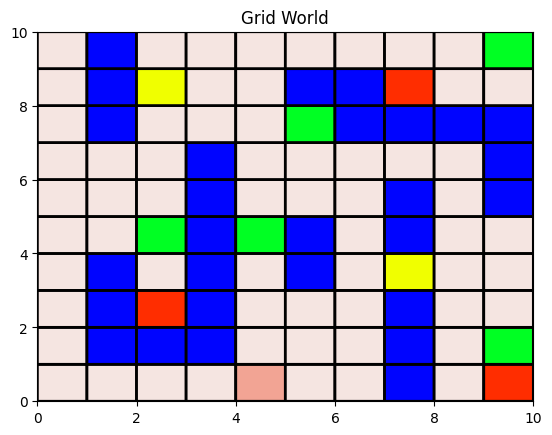

In [15]:
render(env_0_4)

# Experiment 1
- SARSA, wind = False, p = 1.0, Start State = [3,6]

Green -> Bad states
Yellow -> Restart states
Red -> Goal states
Blue -> Obstructed states
Peach -> Start state


C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


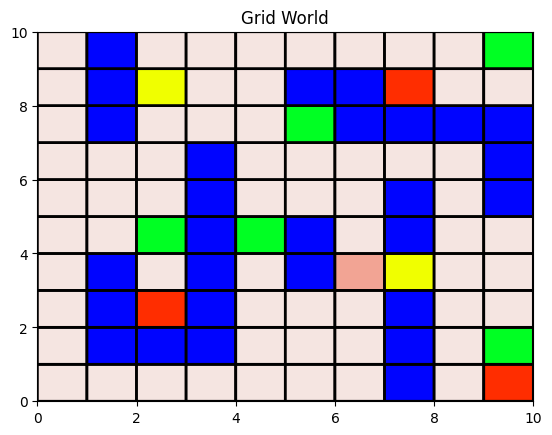

Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



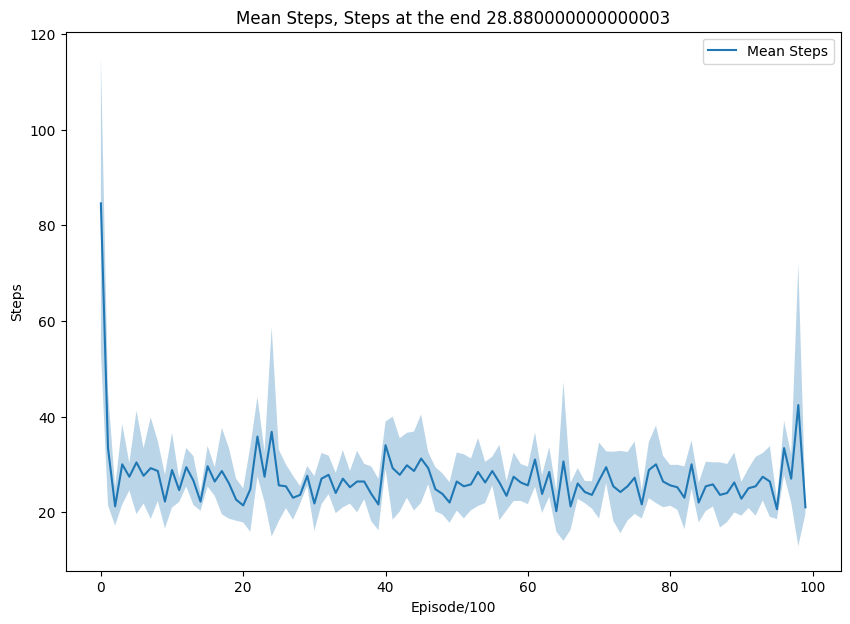

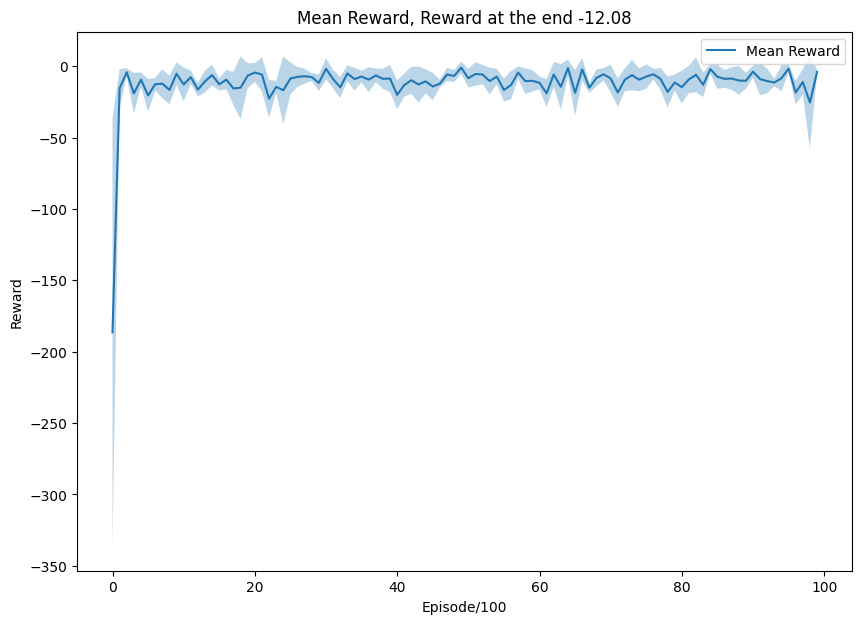

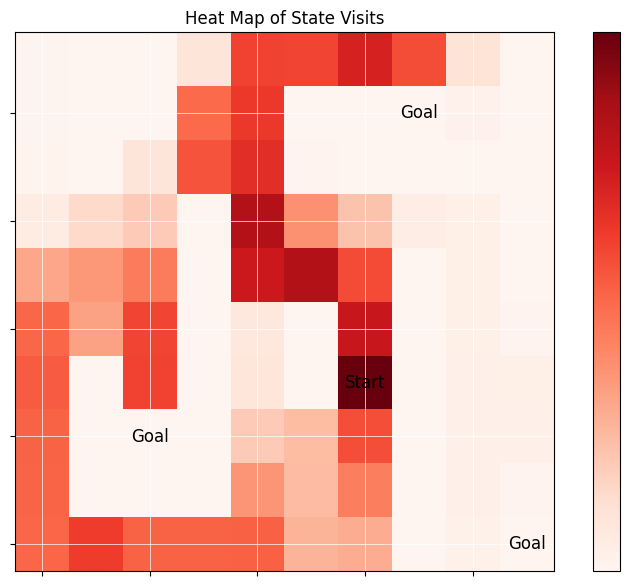

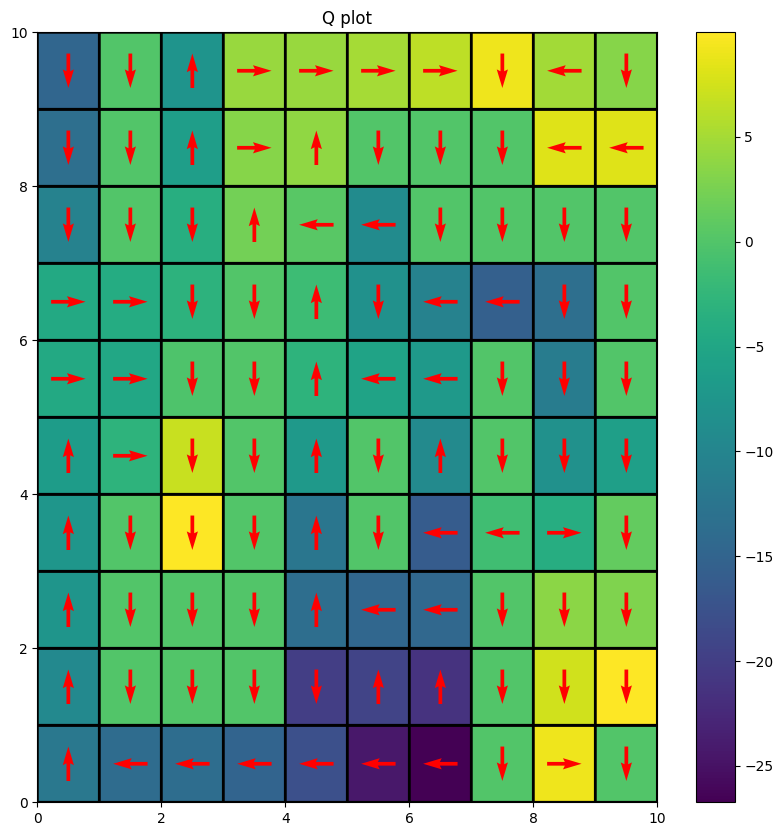

In [20]:
env_3_6.wind = False
env_3_6.reset()
seed = 42
rg = np.random.RandomState(seed)
alpha = 0.5
gamma = 1.0
episodes = 10000
b = 0.5
p = 1.0
wind = False
avg_over = 5
policy = softmax_policy
tau = 0.5
epsilon = 0.9


render(env_3_6, False)
Q, steps, reward, state_visit = train_agent(env_3_6, policy, alpha, gamma, tau, episodes, b, p, avg_over, run_episode_SARSA, "softmax")
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit)
plot_Q(Q, "Q plot")

# Experiment 2
- Q-Learning, wind = False, p = 1.0, Start State = [3,6]

C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



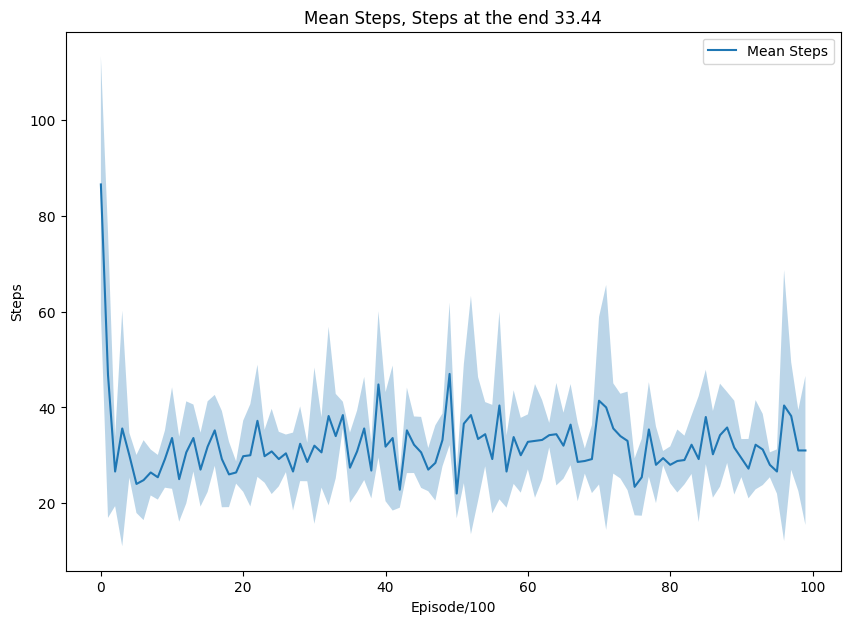

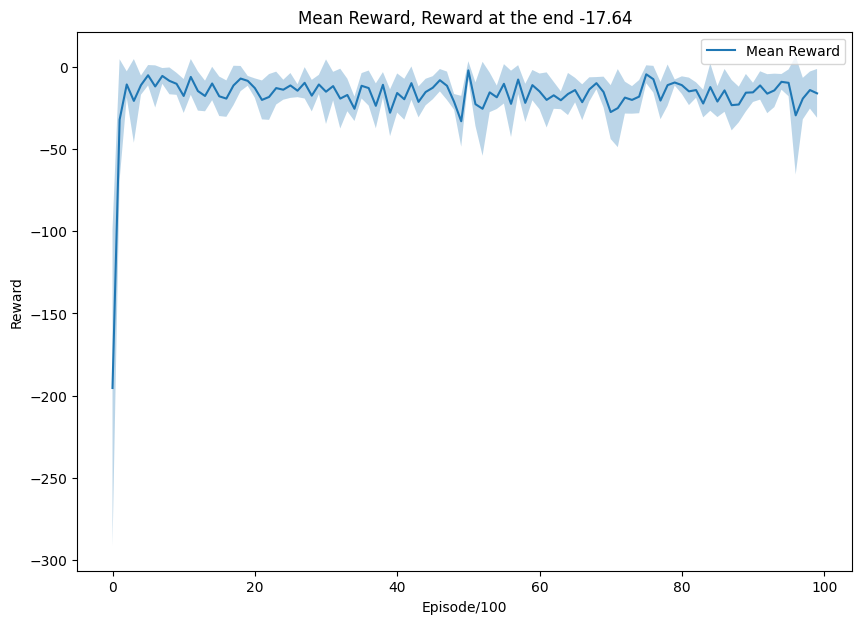

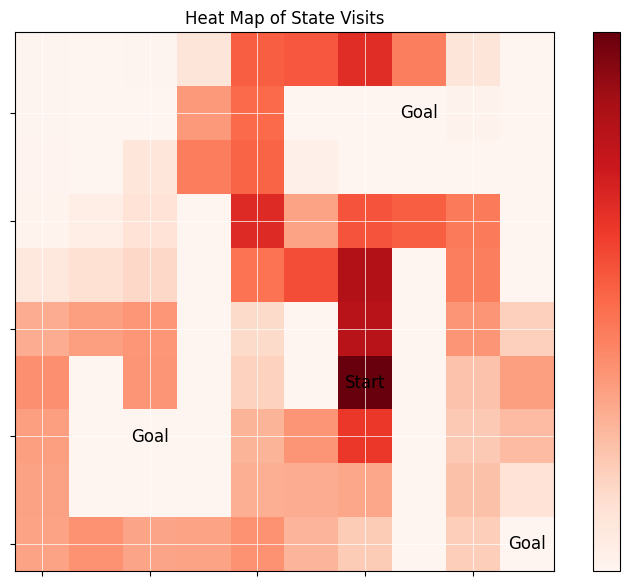

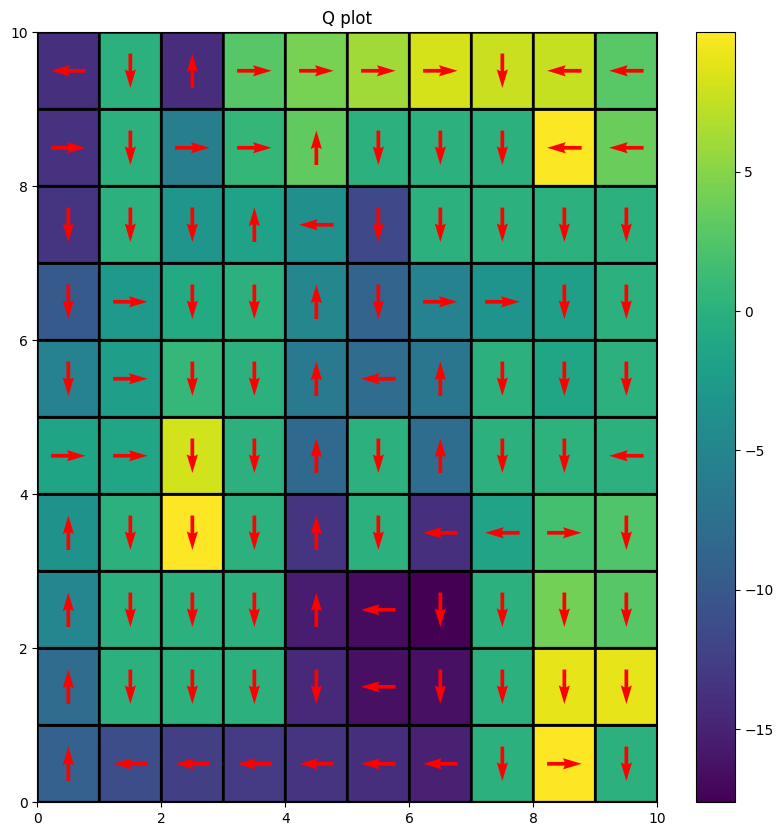

In [30]:
env_3_6.reset()
env_3_6.wind = False

seed = 42
rg = np.random.RandomState(seed)
alpha = 0.5
gamma = 1.0
episodes = 10000
plot_steps_reward = True
b = 0.5
p = 1.0
wind = False
policy = softmax_policy
tau = 1.0

Q, steps, reward, state_visit = train_agent(env_3_6, policy, alpha, gamma, tau, episodes, b, p, avg_over, run_episode_Q_Learning, "softmax")
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit)
plot_Q(Q, "Q plot")

# Experiment 3
- SARSA, wind = False, p = 1.0, Start State = [0,4]

C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



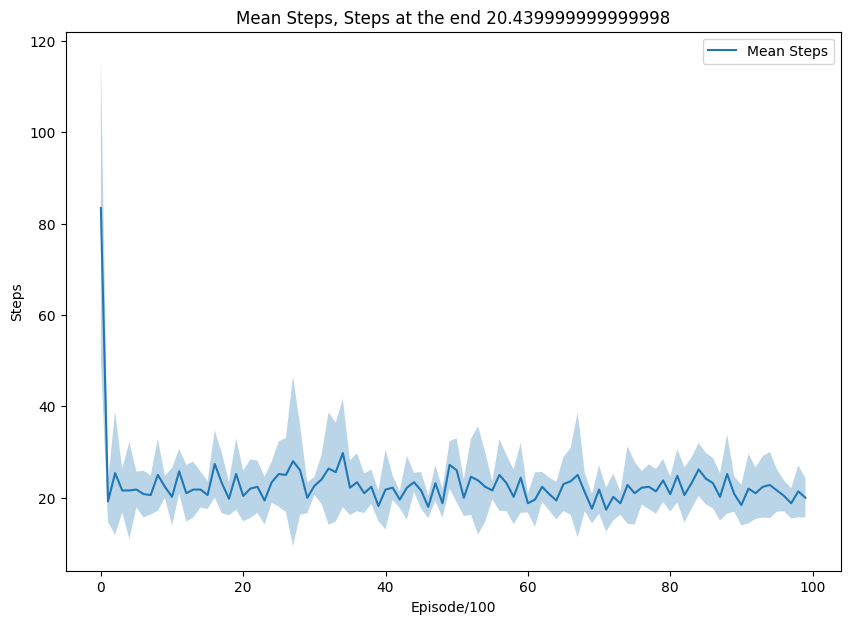

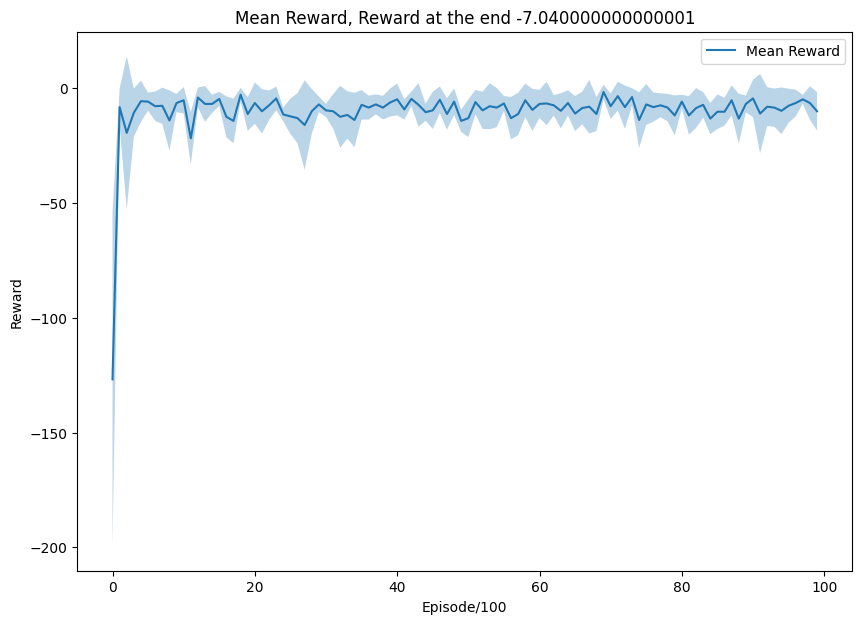

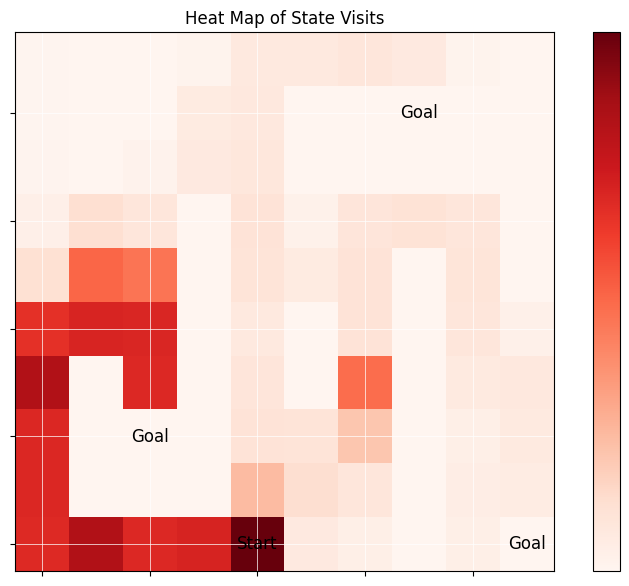

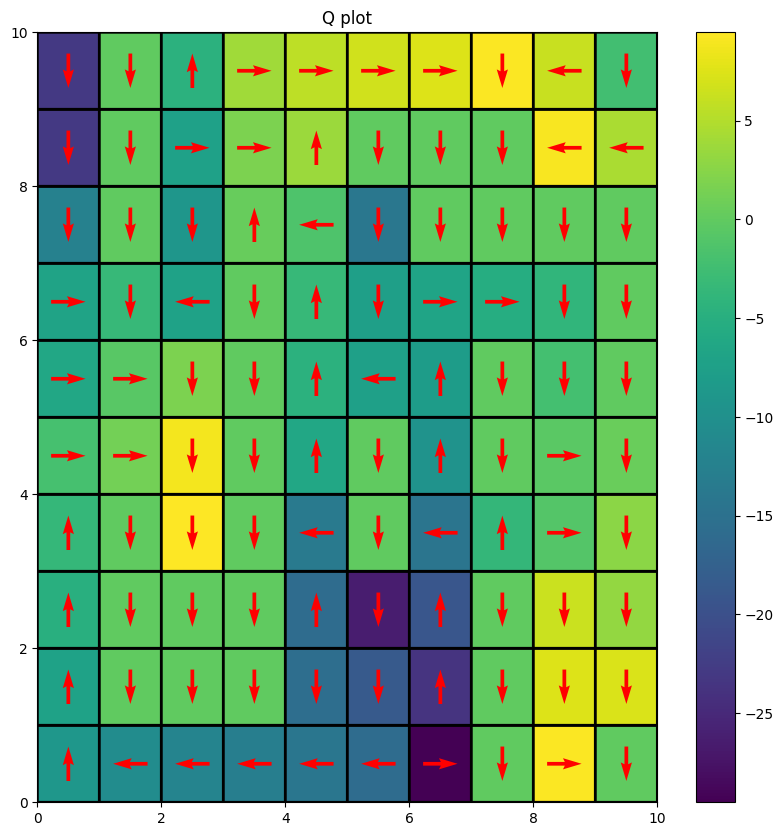

In [17]:
env_0_4.reset()
env_0_4.wind = False

seed = 42
rg = np.random.RandomState(seed)
alpha = 0.5
gamma = 1.0
episodes = 10000
plot_steps_reward = True
b = 0.5
p = 1.0
wind = False
avg_over = 5
Proab_wind = 0.4
policy = softmax_policy
tau = 0.5
epsilon = 0.5

Q, steps, reward, state_visit = train_agent(env_0_4, policy, alpha, gamma, epsilon, episodes, b, p, avg_over, run_episode_SARSA,"softmax")
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit, start_state=[0,4])
plot_Q(Q, "Q plot")

# Experiment 4
- Q-Learning, wind = False, p = 1.0, Start State = [0,4]

C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



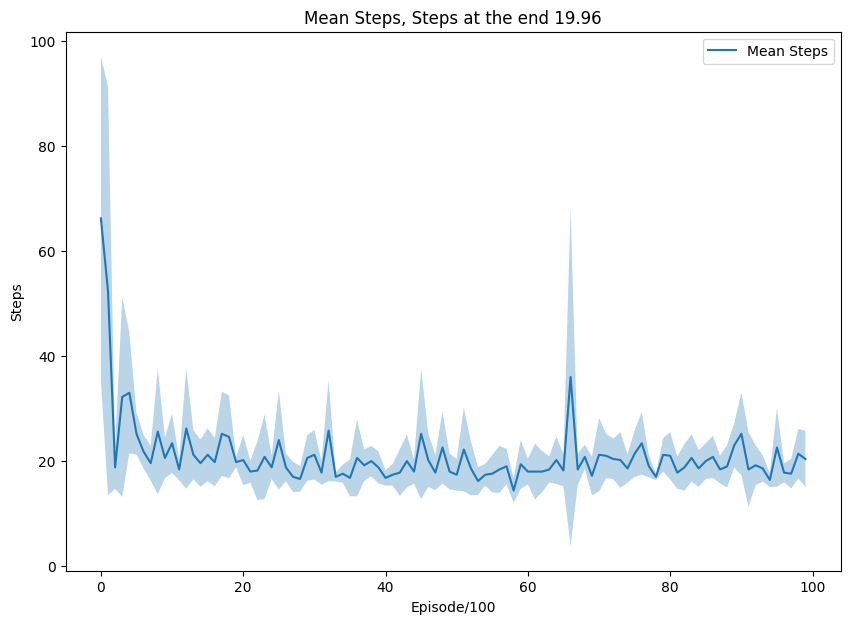

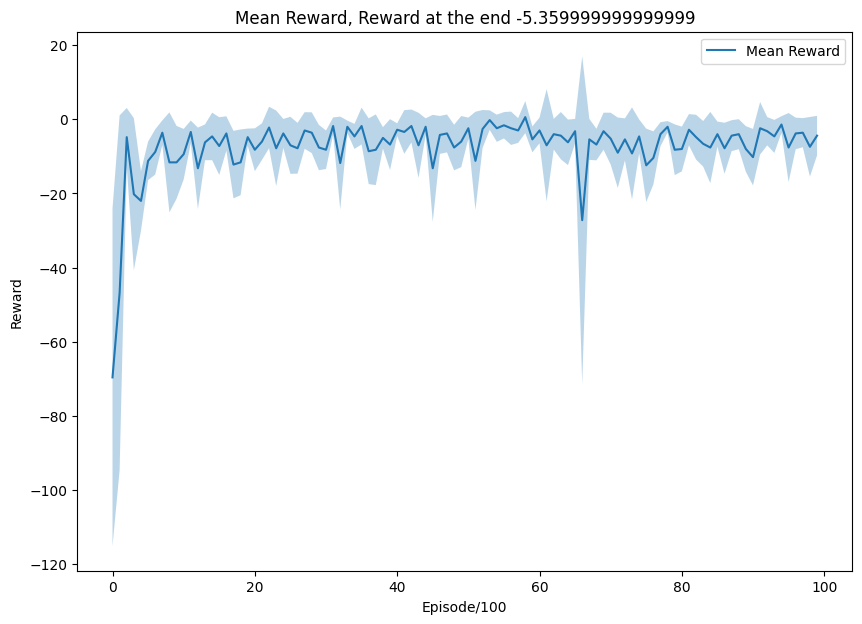

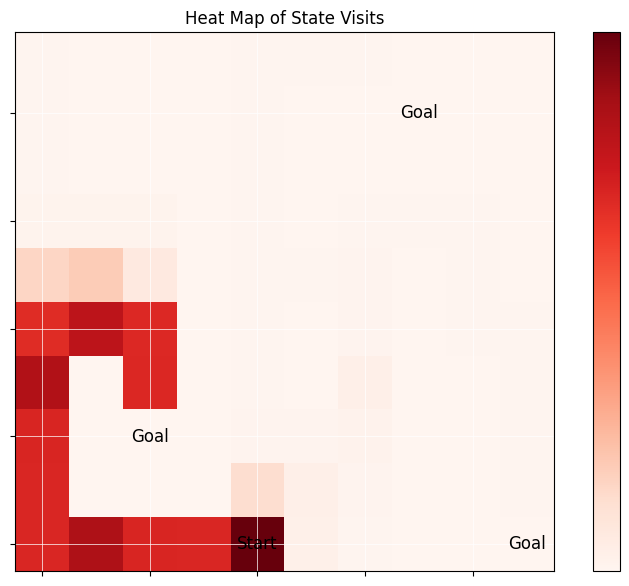

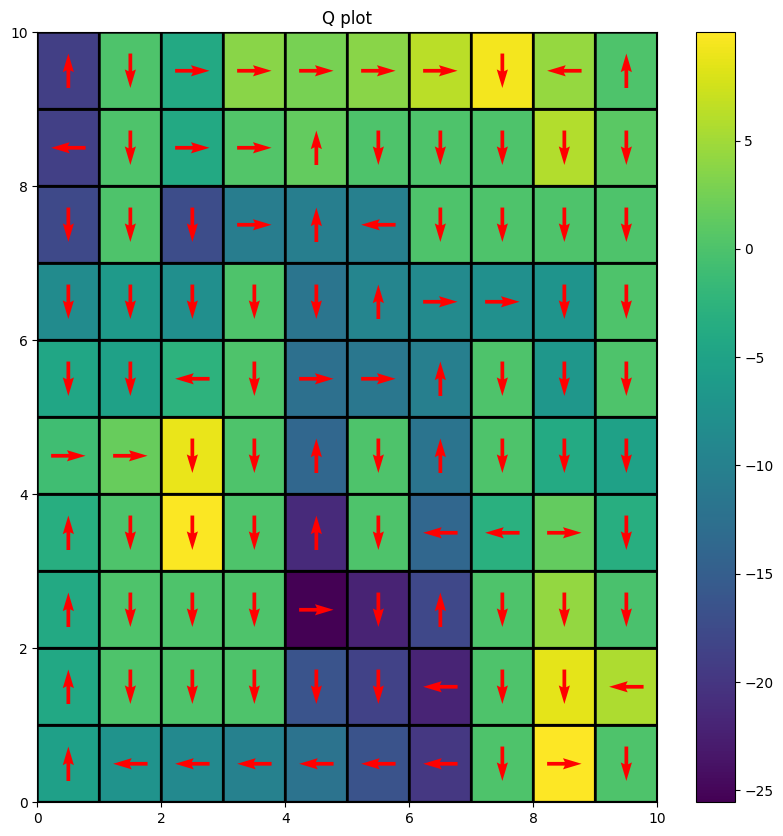

In [19]:
env_0_4.reset()
env_0_4.wind = False
seed = 42
rg = np.random.RandomState(seed)
alpha = 0.5
gamma = 1.0
episodes = 10000
plot_steps_reward = True
b = 0.5
p = 1.0
wind = False
policy = epsilon_policy
tau = 0.5
epsilon = 0.5

Q, steps, reward, state_visit = train_agent(env_0_4, policy, alpha, gamma, epsilon, episodes, b, p, avg_over, run_episode_Q_Learning, "epsilon")
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit, start_state=[0,4])
plot_Q(Q, "Q plot")

# Experiment 5
- SARSA, wind = False, p = 0.7, Start State = [3,6]

C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



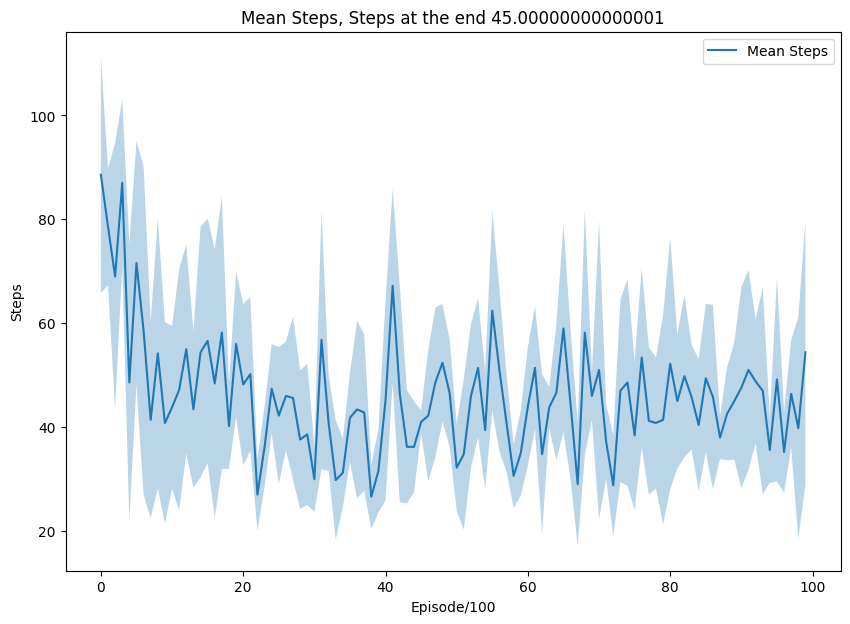

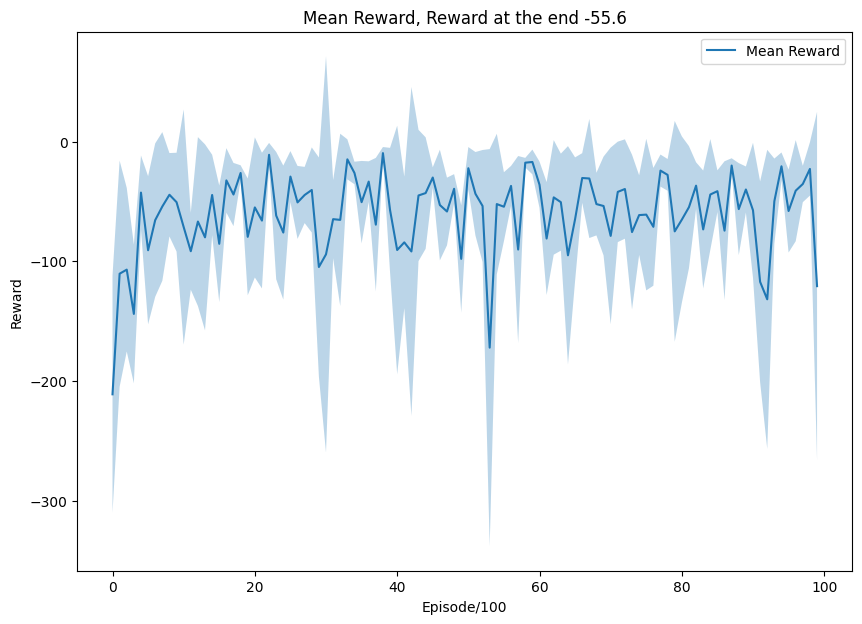

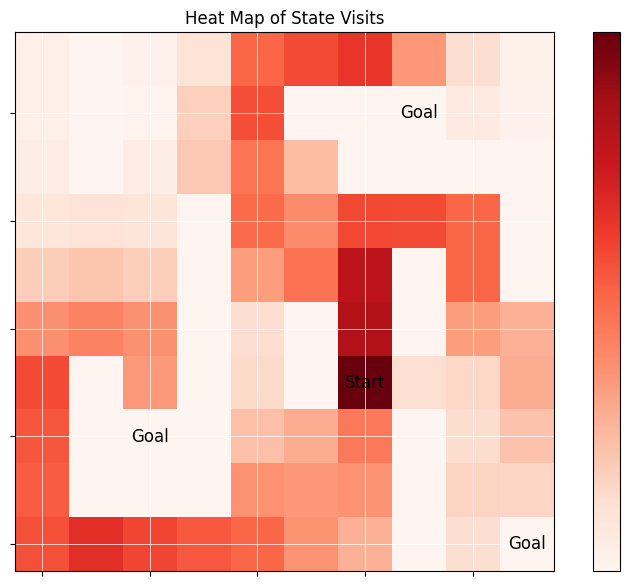

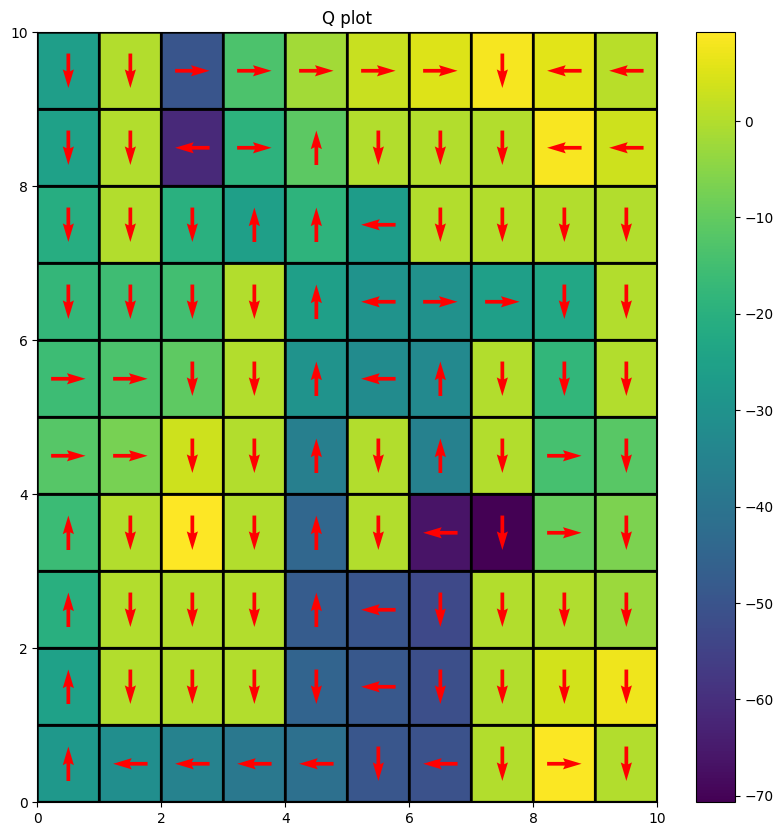

In [25]:
env_3_6.reset()
env_3_6.wind = False

seed = 42
rg = np.random.RandomState(seed)
alpha = 0.1
gamma = 1.0
episodes = 10000
epsilon = 0.6
plot_steps_reward = True
b = 0.5
p = 0.7
wind = False
avg_over = 5
Proab_wind = 0.4
policy = softmax_policy
tau = 1.5

Q, steps, reward, state_visit = train_agent(env_3_6, policy, alpha, gamma, tau, episodes, b, p, avg_over, run_episode_SARSA, "softmax")
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit)
plot_Q(Q, "Q plot")

# Experiment 6
- Q-Learning, wind = False, p = 0.7, Start State = [3,6]

C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



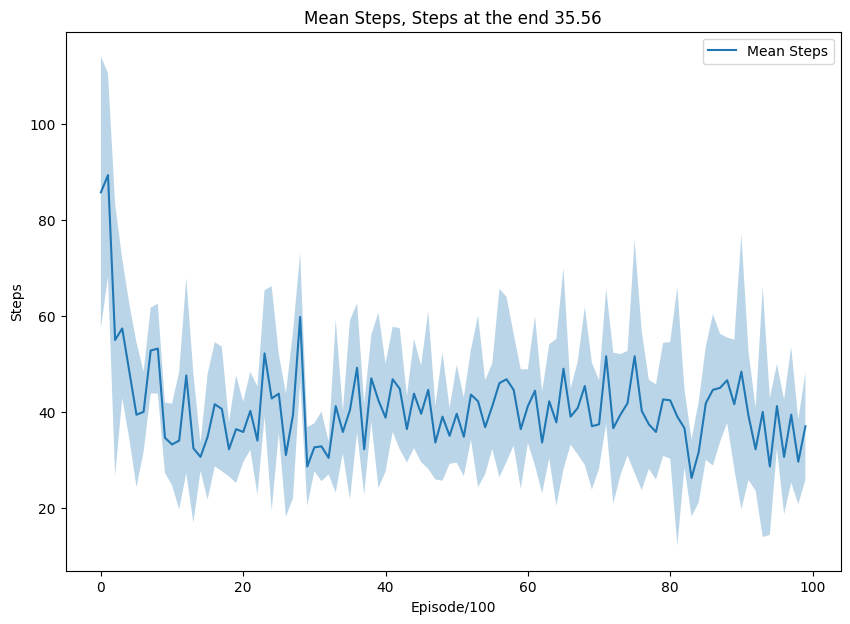

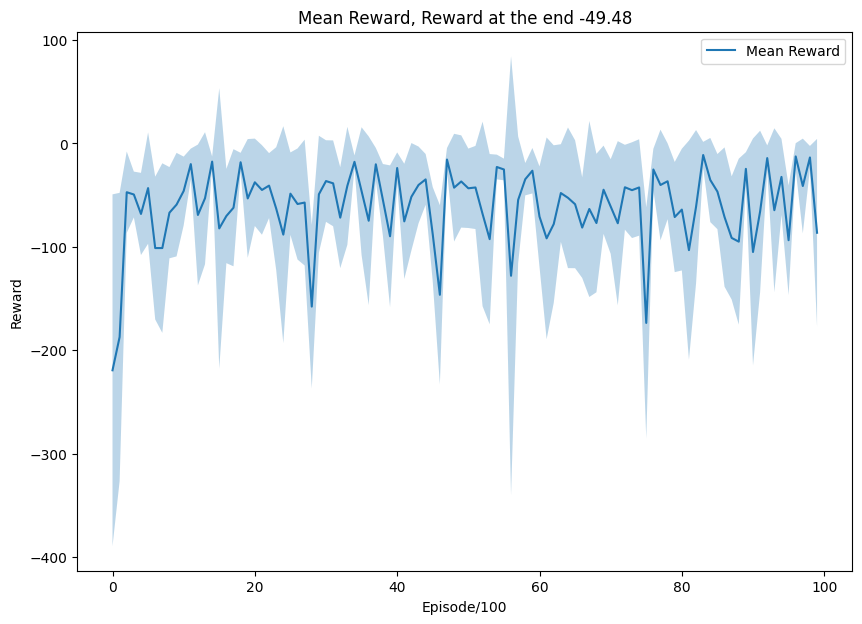

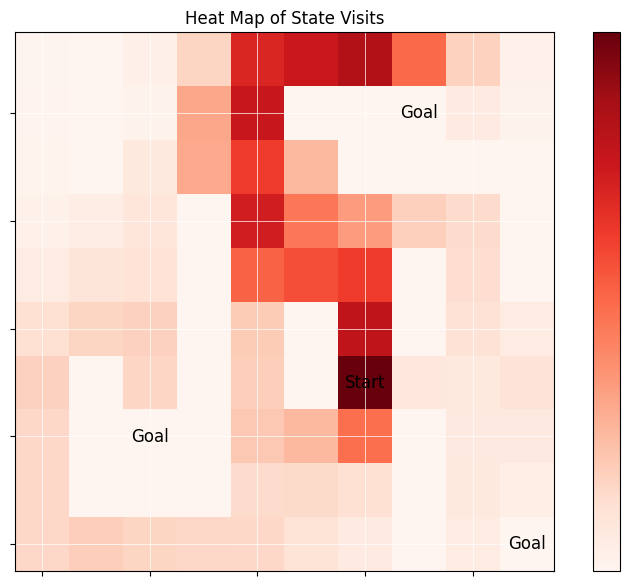

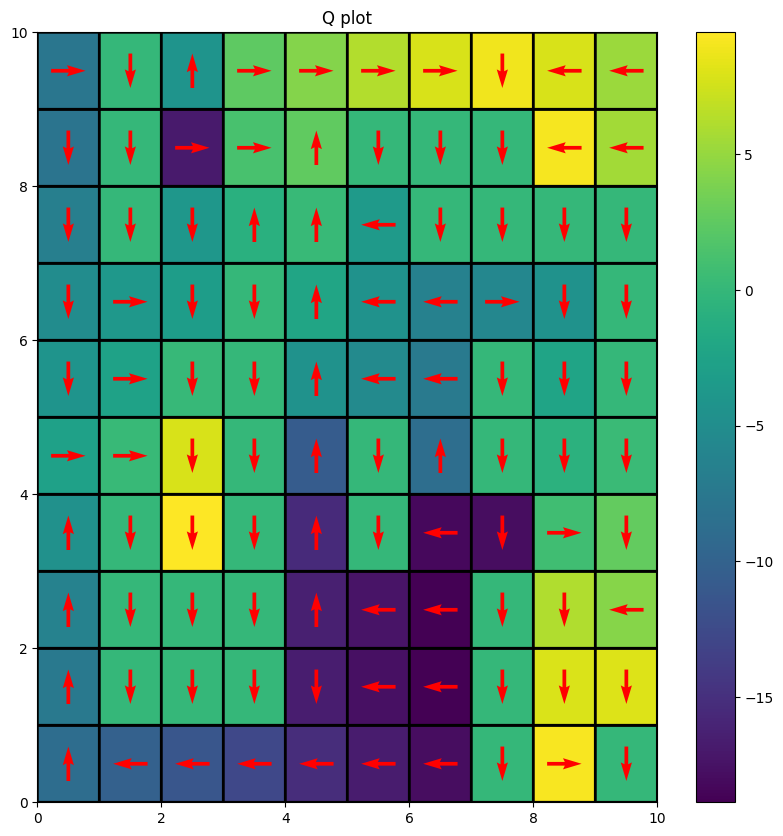

In [26]:
env_3_6.reset()
env_3_6.wind = False

seed = 42
rg = np.random.RandomState(seed)
alpha = 0.1
gamma = 1.0
episodes = 10000
epsilon = 0.6
plot_steps_reward = True
b = 0.5
p = 0.7
wind = False
avg_over = 5
Proab_wind = 0.4
policy = softmax_policy
tau = 0.5

Q, steps, reward, state_visit = train_agent(env_3_6, policy, alpha, gamma, tau, episodes, b, p, avg_over, run_episode_Q_Learning)
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit)
plot_Q(Q, "Q plot")

# Experiment 7
- SARSA, wind = False, p = 0.7, Start State = [0,4]

C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



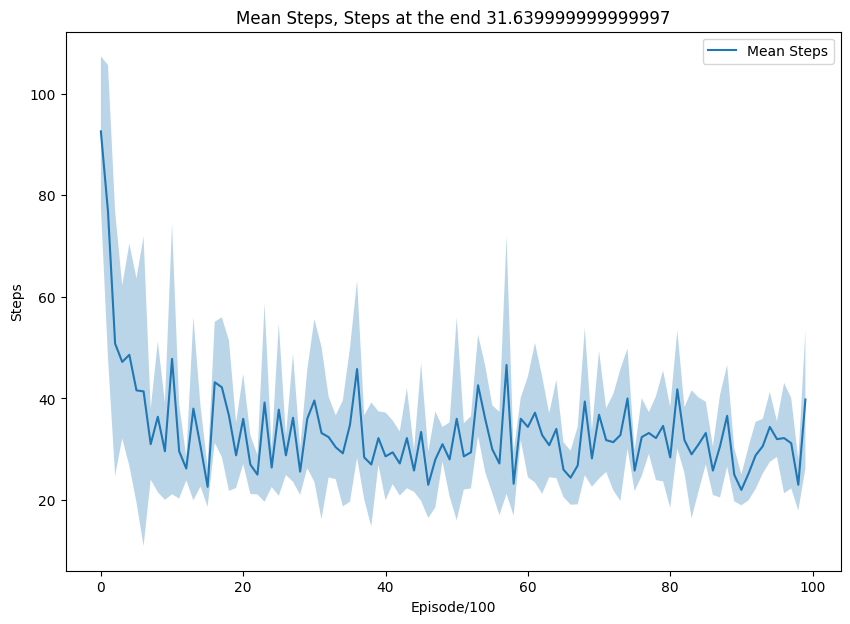

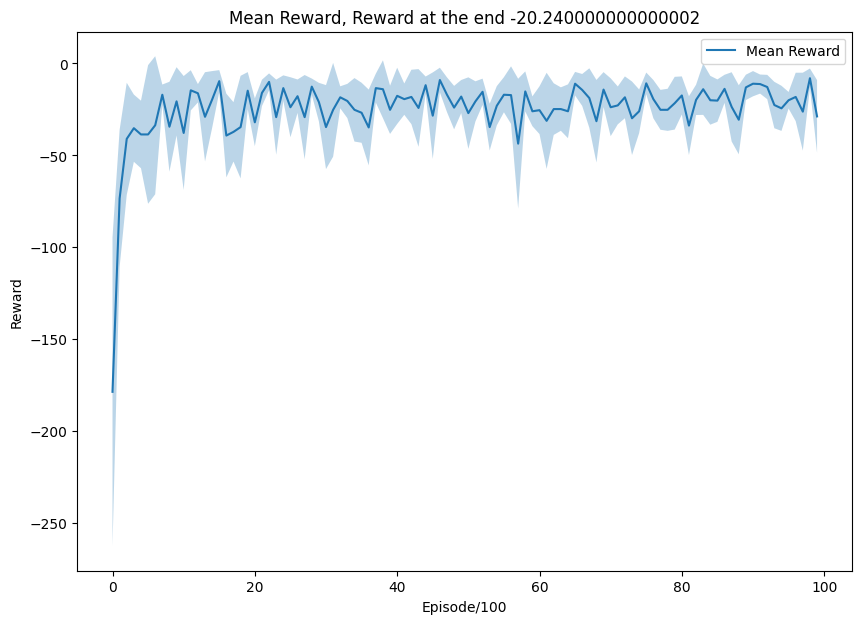

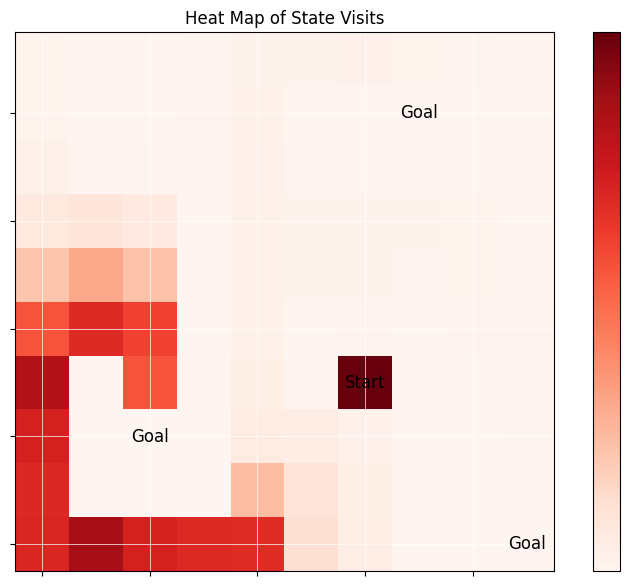

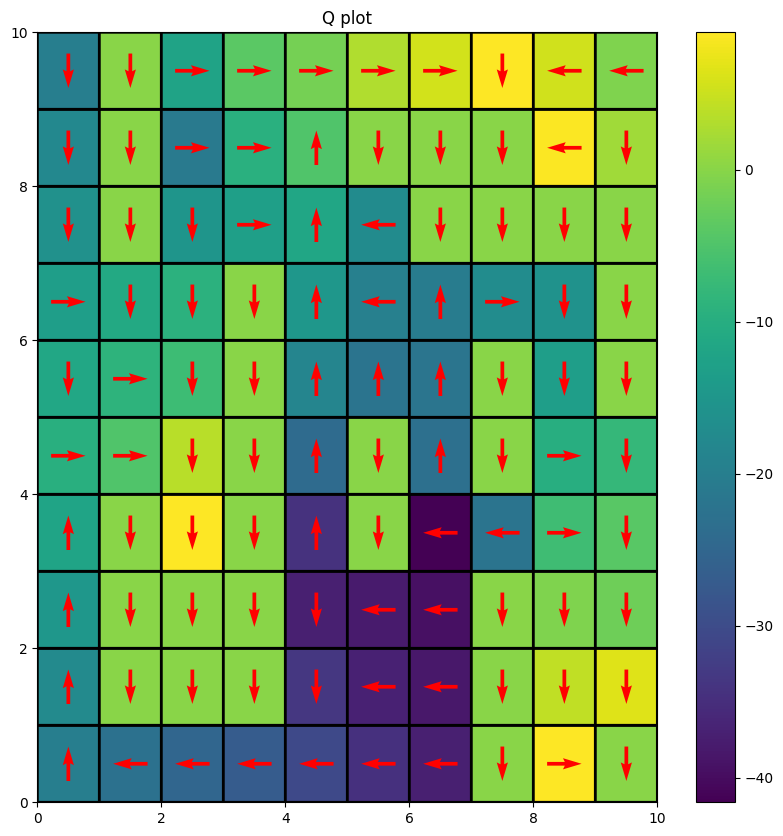

In [27]:
env_0_4.reset()
env_0_4.wind = False

seed = 42
rg = np.random.RandomState(seed)
alpha = 0.1
gamma = 1.0
episodes = 10000
epsilon = 0.6
plot_steps_reward = True
b = 0.5
p = 0.7
wind = False
avg_over = 5
Proab_wind = 0.4
policy = softmax_policy
tau = 0.5

Q, steps, reward, state_visit = train_agent(env_0_4, policy, alpha, gamma, tau, episodes, b, p, avg_over, run_episode_SARSA)
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit)
plot_Q(Q, "Q plot")

# Experiment 8
- Q-Learning, wind = False, p = 0.7, Start State = [0,4]

C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



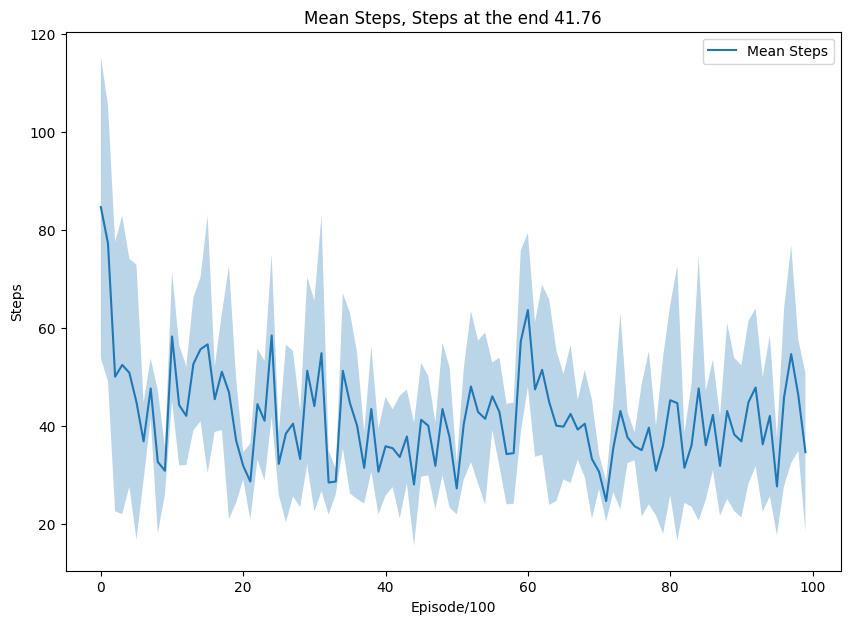

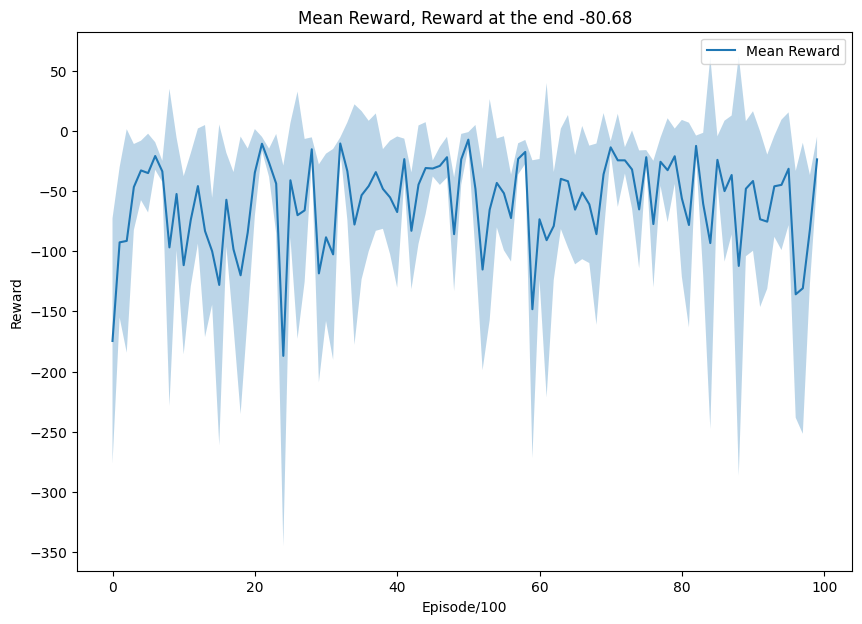

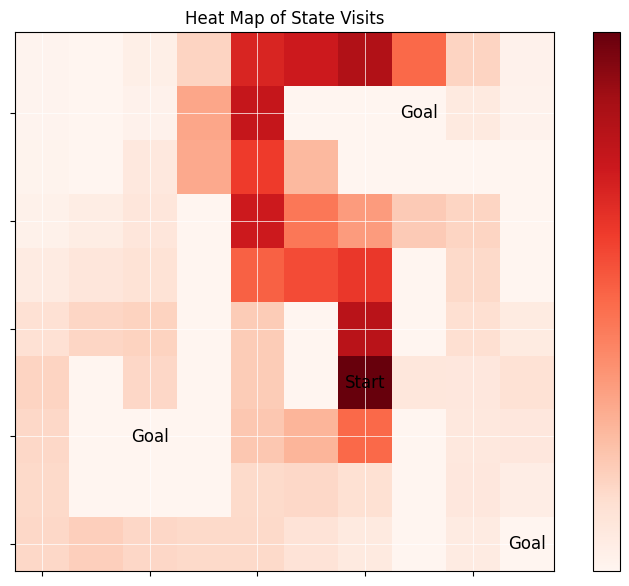

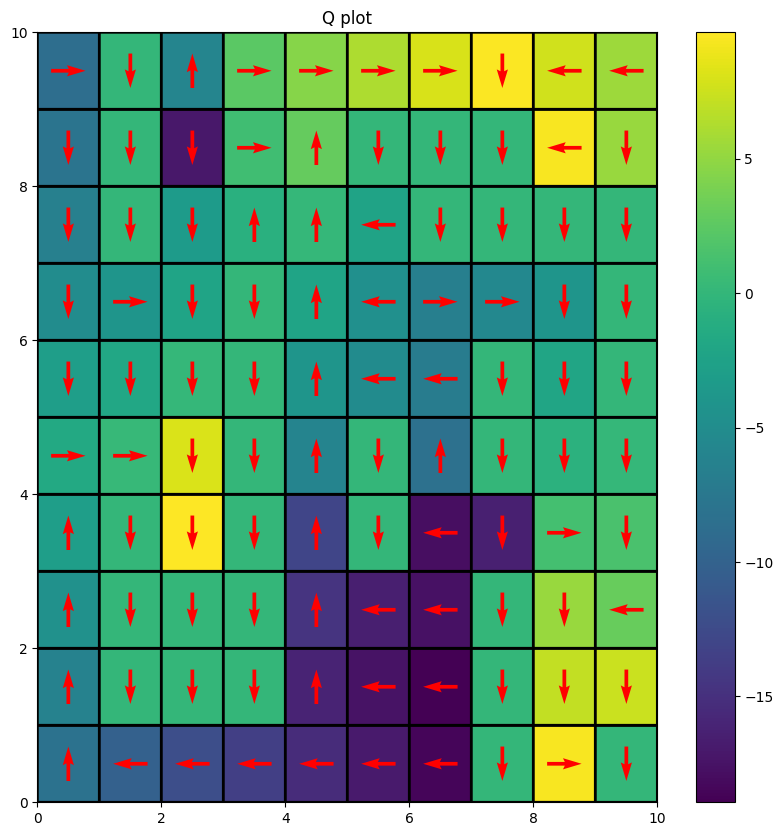

In [28]:
env_3_6.reset()
env_3_6.wind = False

seed = 42
rg = np.random.RandomState(seed)
alpha = 0.1
gamma = 1.0
episodes = 10000
epsilon = 0.6
plot_steps_reward = True
b = 0.5
p = 0.7
wind = False
avg_over = 5
Proab_wind = 0.4
policy = softmax_policy
tau = 0.5

Q, steps, reward, state_visit = train_agent(env_3_6, policy, alpha, gamma, tau, episodes, b, p, avg_over, run_episode_Q_Learning)
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit)
plot_Q(Q, "Q plot")

# Experiment 9
- SARSA, wind = True, p = 1.0, Start State = [3,6]

C:\Users\akran\AppData\Local\Temp\ipykernel_15524\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



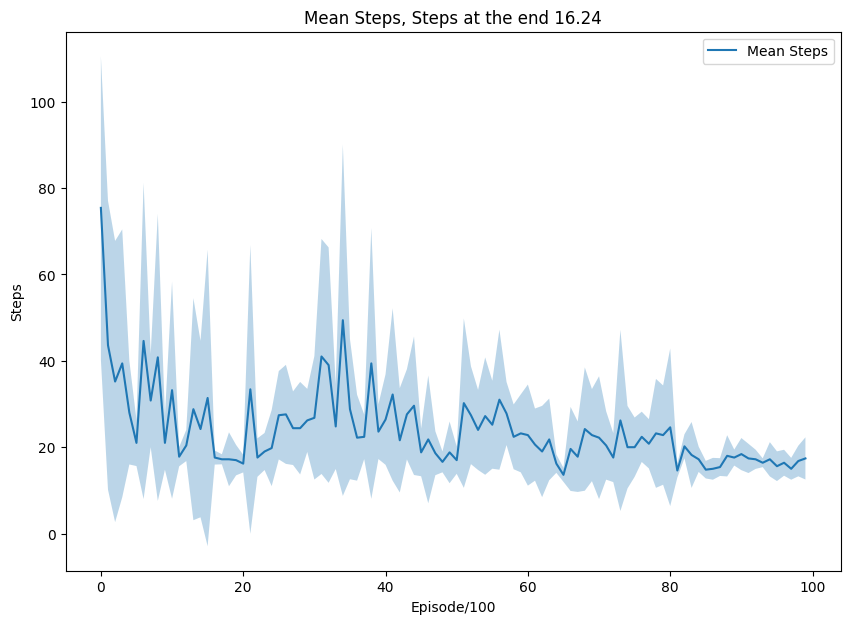

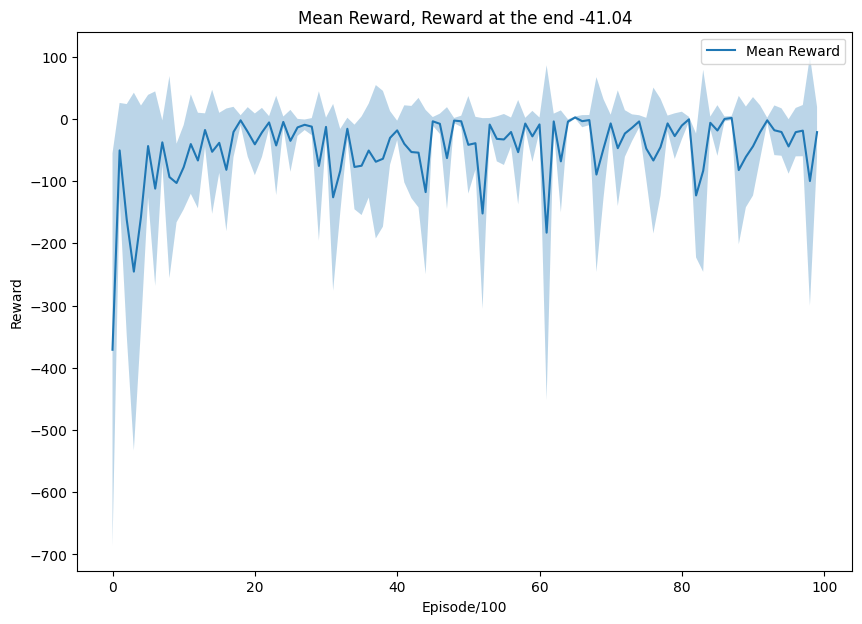

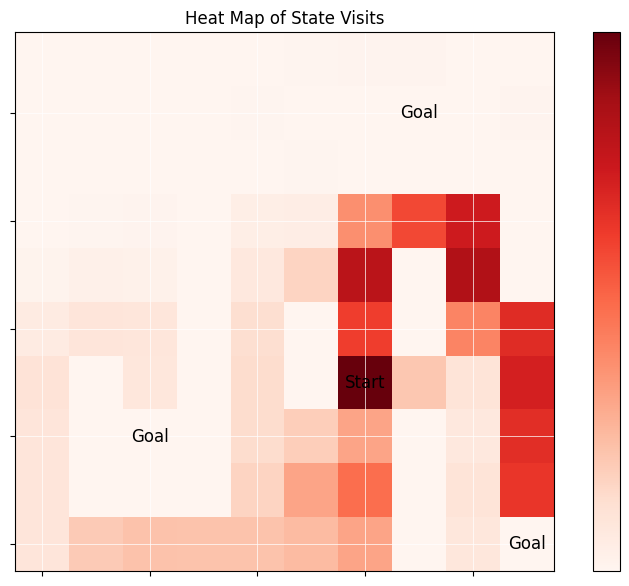

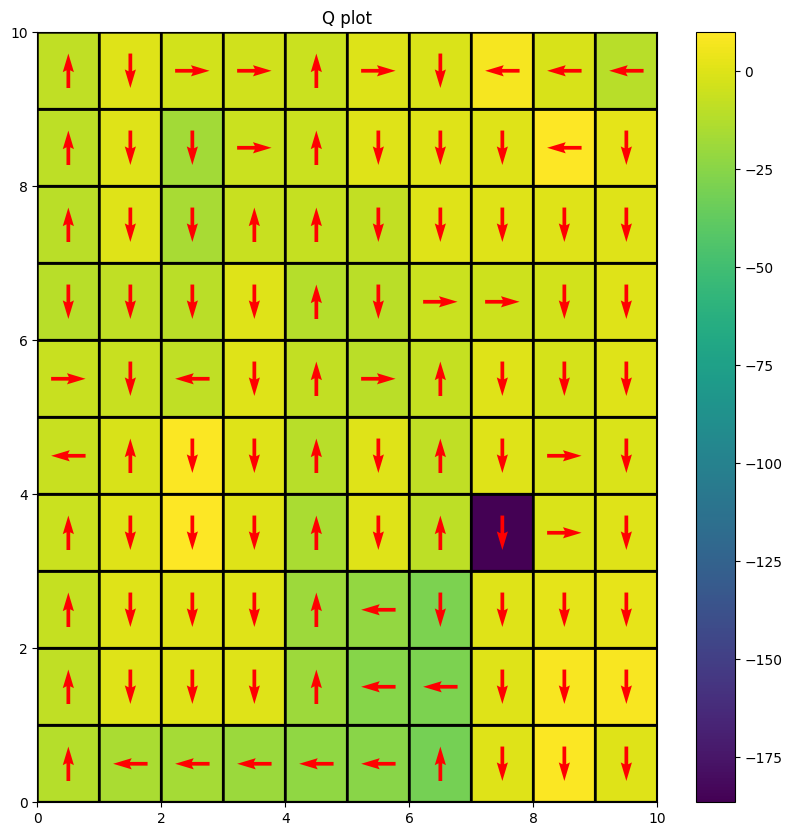

In [36]:
env_3_6.reset()
env_3_6.wind = True

alpha = 0.5
gamma = 1.0
episodes = 10000
plot_steps_reward = True
b = 0.5
p = 1.0
wind = True
avg_over = 5
Proab_wind = 0.4
policy = epsilon_policy
epsilon = 0.5
tau = 0.5

Q, steps, reward, state_visit = train_agent(env_3_6, policy, alpha, gamma, epsilon, episodes, b, p, avg_over, run_episode_SARSA,"epsilon") 
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit)
plot_Q(Q, "Q plot")

# Experiment 10
- Q-Learning, wind = True, p = 1.0, Start State = [3,6]

C:\Users\akran\AppData\Local\Temp\ipykernel_15524\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1


Running for 2
Running for 3
Running for 4
Running for 5



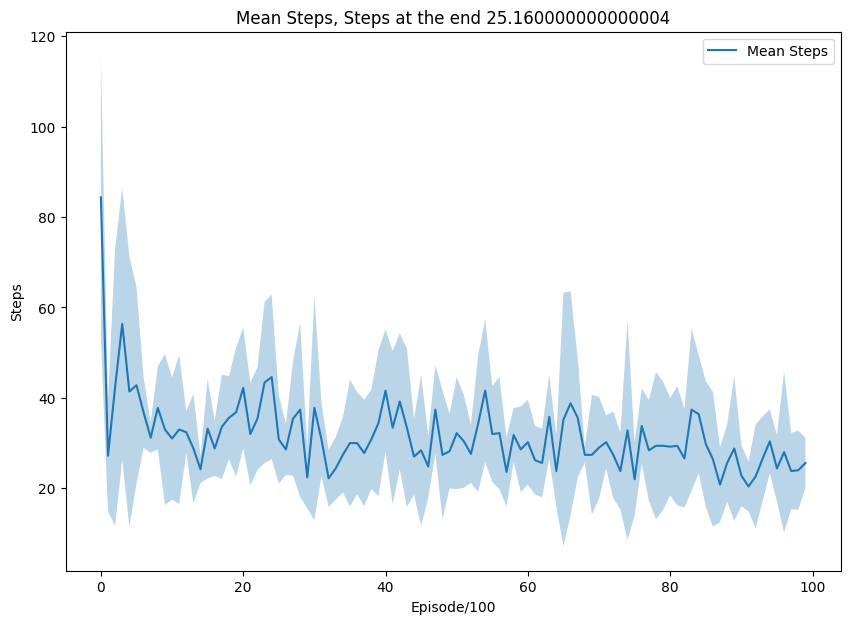

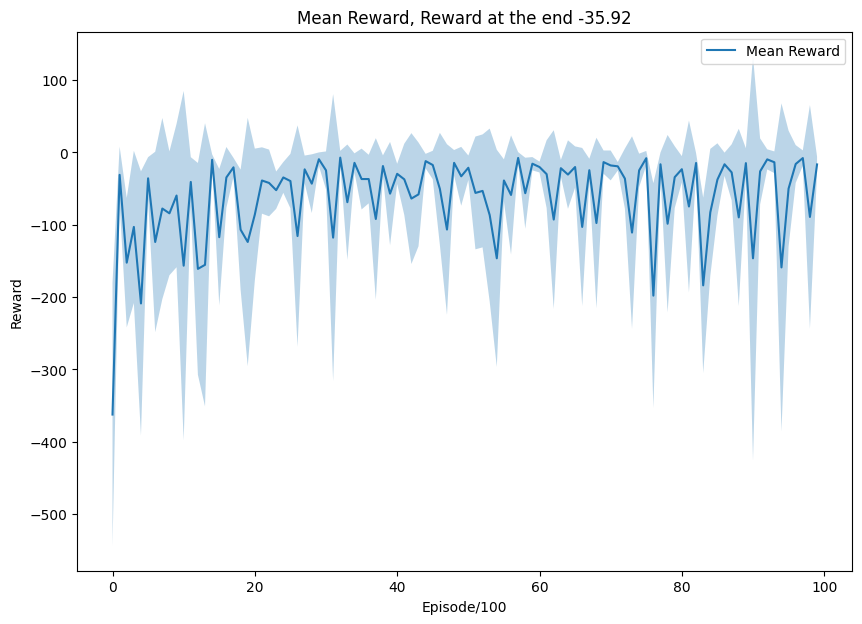

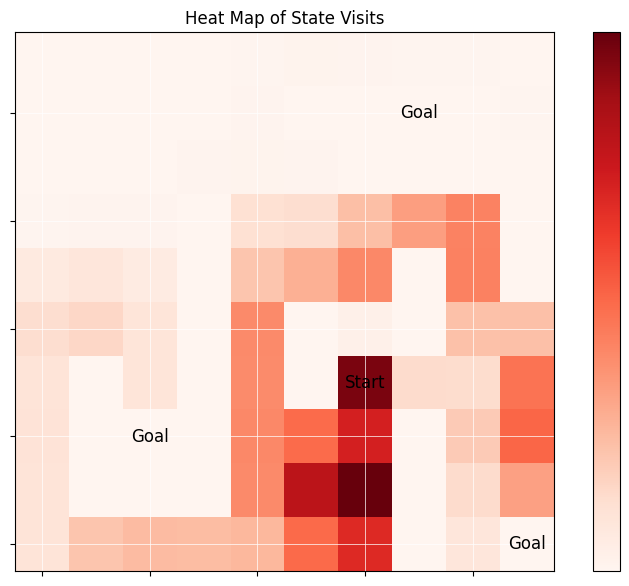

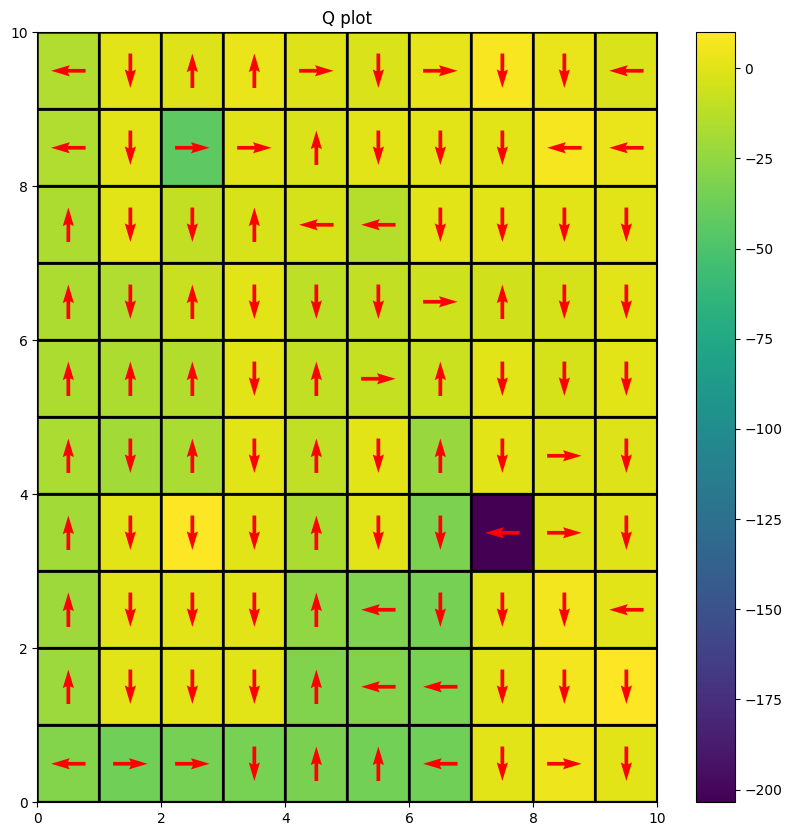

In [40]:
env_3_6.reset()
env_3_6.wind = True
seed = 42
rg = np.random.RandomState(seed)
alpha = 0.5
gamma = 1.0
episodes = 10000
epsilon = 0.6
plot_steps_reward = True
b = 0.5
p = 1.0
wind = True
avg_over = 5
Proab_wind = 0.4
policy = epsilon_policy
epsilon = 0.6
tau = 0.5


Q, steps, reward, state_visit = train_agent(env_3_6, policy, alpha, gamma, epsilon, episodes, b, p, avg_over, run_episode_Q_Learning,"epsilon")
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit)
plot_Q(Q, "Q plot")

# Experiment 11
- SARSA, wind = True, p = 1.0, Start State = [0,4]

C:\Users\akran\AppData\Local\Temp\ipykernel_15524\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



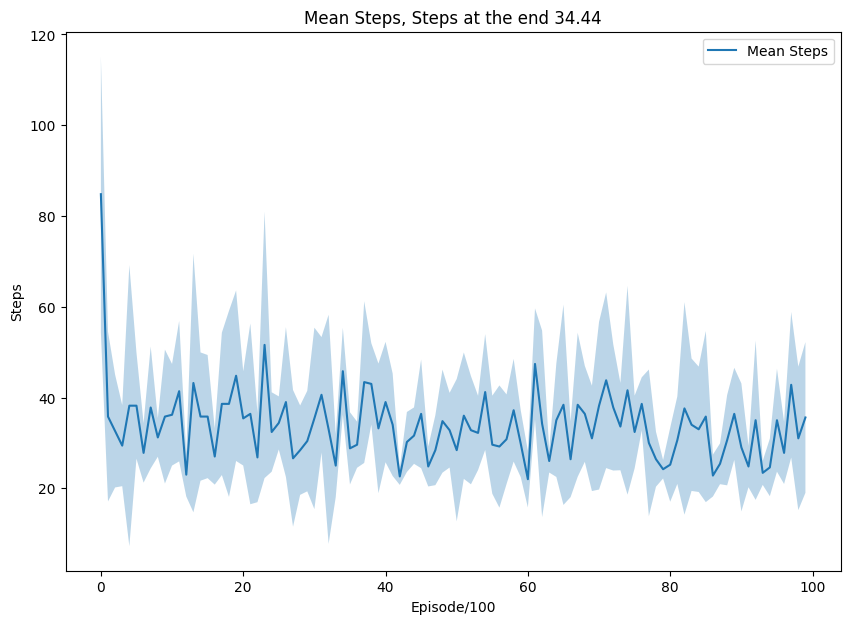

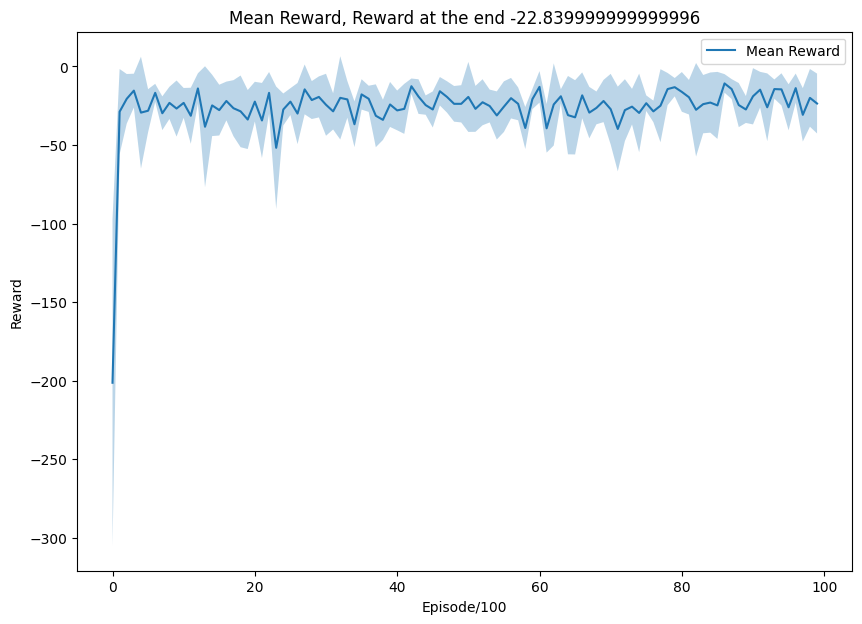

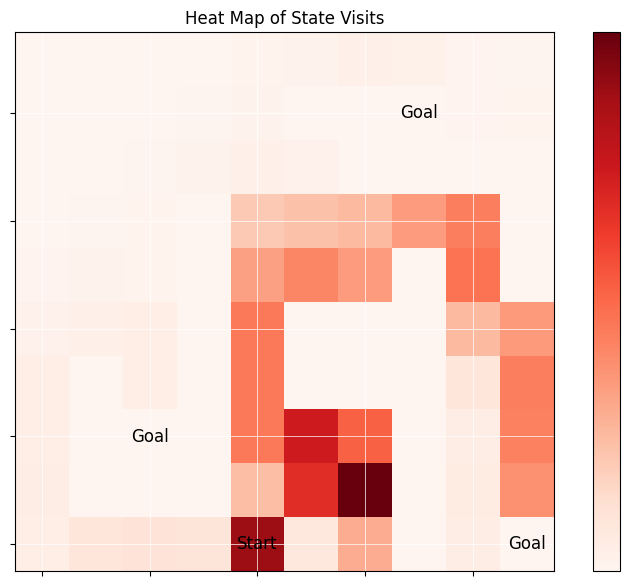

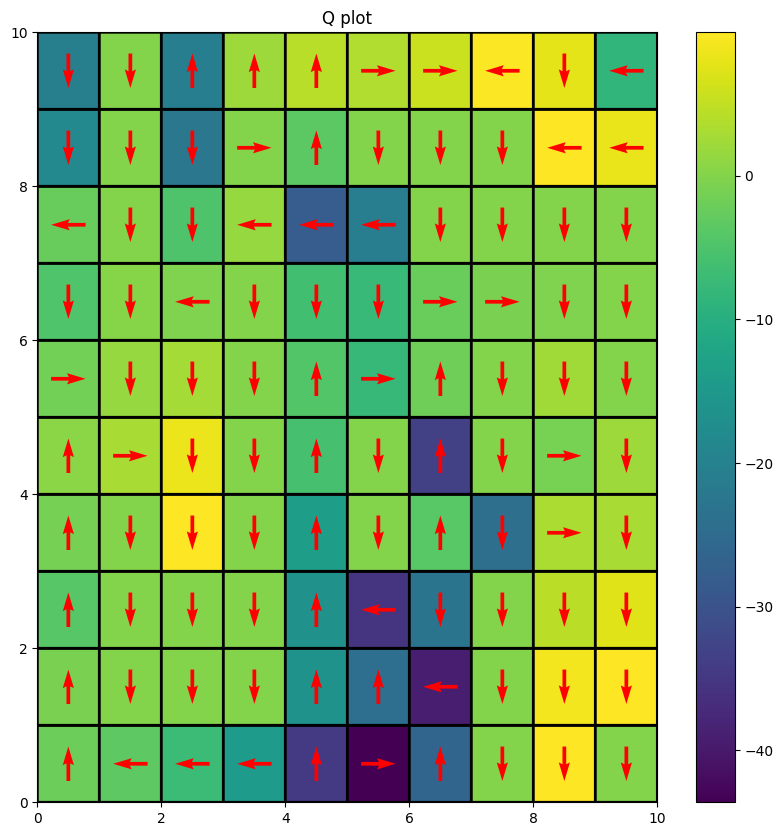

In [27]:
env_0_4.reset()
env_0_4.wind = True

seed = 42
rg = np.random.RandomState(seed)
alpha = 0.9
gamma = 1.0
episodes = 10000
epsilon = 0.6
plot_steps_reward = True
b = 0.5
p = 1.0
wind = True
avg_over = 5
Proab_wind = 0.4
policy = softmax_policy
tau = 0.5

Q, steps, reward, state_visit = train_agent(env_0_4, policy, alpha, gamma, tau, episodes, b, p, avg_over, run_episode_SARSA)
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit, start_state=[0,4])
plot_Q(Q, "Q plot")

# Experiment 12
- Q-Learning, wind = True, p = 1.0, Start State = [0,4]

C:\Users\akran\AppData\Local\Temp\ipykernel_4360\1366618099.py:180: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)


Running for 1
Running for 2
Running for 3
Running for 4
Running for 5



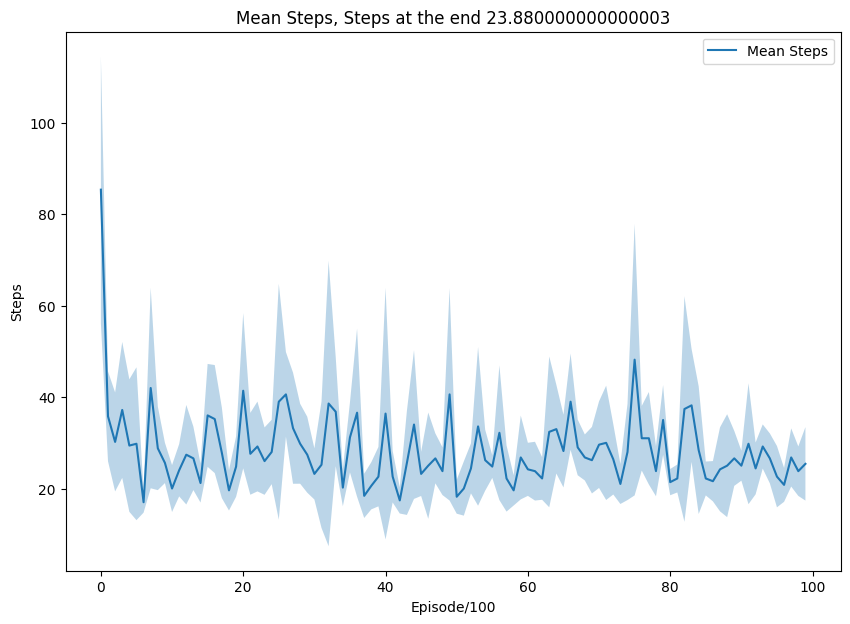

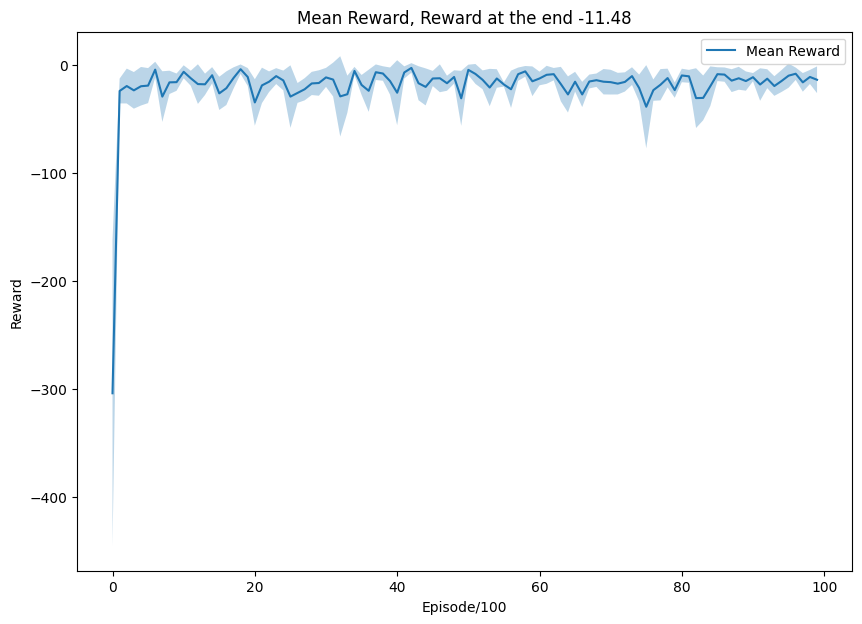

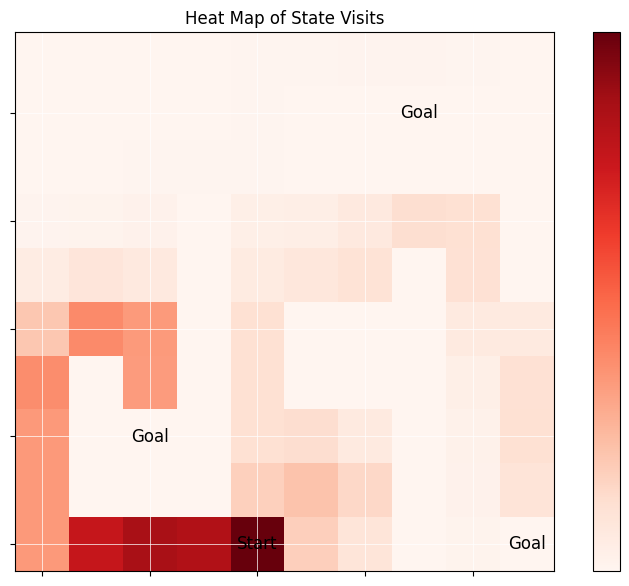

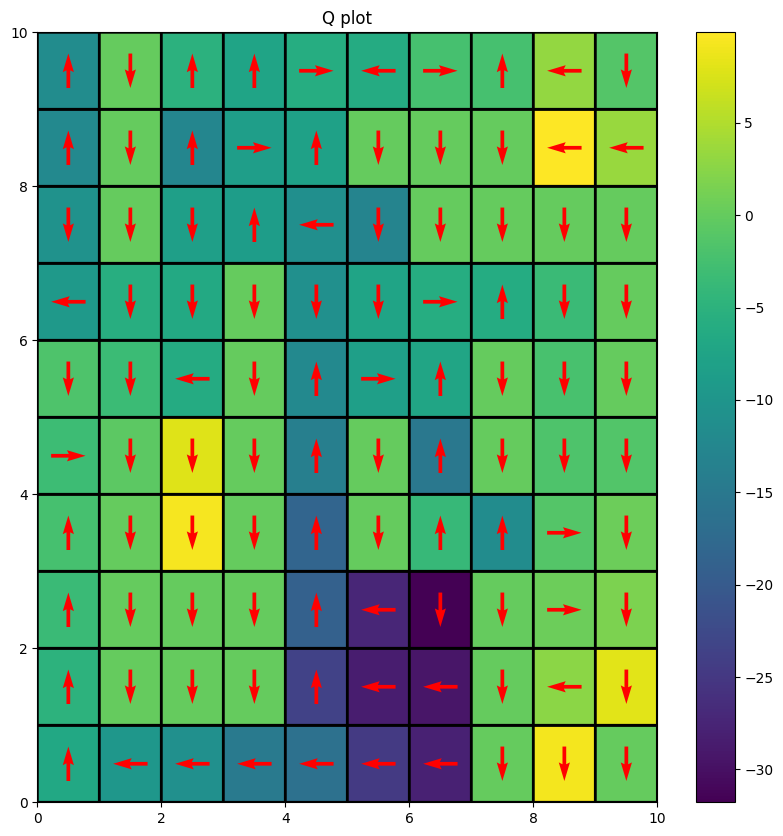

In [29]:
env_0_4.reset()
env_0_4.wind = True

seed = 42
rg = np.random.RandomState(seed)
alpha = 0.5
gamma = 1.0
episodes = 10000
plot_steps_reward = True
b = 0.5
p = 1.0
wind = True
avg_over = 5
Proab_wind = 0.4
policy = softmax_policy
tau = 0.5

Q, steps, reward, state_visit = train_agent(env_0_4, policy, alpha, gamma, tau, episodes, b, p, avg_over, run_episode_Q_Learning, "softmax")
plot_train_reward_steps(steps, reward)
plot_heat_map(state_visit, start_state=[0,4])
plot_Q(Q, "Q plot")